# **Judul: Analisis Perbandingan Model Bi-LSTM dan IndoBERT untuk Klasifikasi Emosi Ulasan Aplikasi AHM Mobile Periode 2020 hingga 2024**

# **Membaca Dataset**

In [ ]:
# Upload file dari lokal
from google.colab import files
uploaded = files.upload()
import pandas as pd
import io

# Ambil nama file dari dictionary
filename = next(iter(uploaded))

# Baca CSV ke DataFrame
df_ahm = pd.read_csv(io.BytesIO(uploaded[filename]))

# Tampilkan data
print("Data berhasil diimport:")
df_ahm


Saving ulasan_ahm_mobile_hasillabelling_2020-2024 - Manual.csv to ulasan_ahm_mobile_hasillabelling_2020-2024 - Manual (2).csv
Data berhasil diimport:


,at,content,emotion_label
0,2024-11-19 2:12:16,Tolong lah ya sekelas AHM masa servernya berat...,muak
1,2024-10-24 9:41:05,Ketika lupa password dan sudah direset tidak b...,muak
2,2024-10-16 14:15:09,Mantap,senang
3,2024-10-03 6:48:00,Password gagal diperbaharui -_-,muak
4,2024-09-26 11:08:16,Tolong dong jangan dikit² logout. Ganti paswor...,marah
...,...,...,...
1225,2020-01-02 0:45:58,Kurang,netral
1226,2020-01-01 23:01:39,Salam satu hati,netral
1227,2020-01-01 15:55:07,Mantap sekalii,senang
1228,2020-01-01 12:01:25,Ajib,senang


In [ ]:
df_ahm['emotion_label'].value_counts()

,count
emotion_label,
marah,314
netral,287
senang,238
muak,185
sedih,141
takut,65


# **Encoding**

In [ ]:
# Mapping label ke angka
label2id = {
    'senang': 0,
    'sedih': 1,
    'marah': 2,
    'takut': 3,
    'netral': 4,
    'muak': 5
}

# Buat kolom label_encoded
df_ahm['label_encoded'] = df_ahm['emotion_label'].map(label2id)

# Tambahkan kolom baru ke dalam urutan tampilan
ordered_columns = [
    'at', 'content', 'emotion_label', 'label_encoded'
]
df_ahm = df_ahm[ordered_columns]
df_ahm

,at,content,emotion_label,label_encoded
0,2024-11-19 2:12:16,Tolong lah ya sekelas AHM masa servernya berat...,muak,5
1,2024-10-24 9:41:05,Ketika lupa password dan sudah direset tidak b...,muak,5
2,2024-10-16 14:15:09,Mantap,senang,0
3,2024-10-03 6:48:00,Password gagal diperbaharui -_-,muak,5
4,2024-09-26 11:08:16,Tolong dong jangan dikit² logout. Ganti paswor...,marah,2
...,...,...,...,...
1225,2020-01-02 0:45:58,Kurang,netral,4
1226,2020-01-01 23:01:39,Salam satu hati,netral,4
1227,2020-01-01 15:55:07,Mantap sekalii,senang,0
1228,2020-01-01 12:01:25,Ajib,senang,0


In [ ]:
# Simpan DataFrame df_ahm sebagai file CSV
df_ahm.to_csv('manual_encode.csv', index=False)

# **Pemodelan Bi-LSTM**

In [ ]:
!pip install torch nltk scikit-learn pandas


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Pastikan kolom content_cleaning dan label_encoded sudah ada di df_ahm
texts = df_ahm['content'].astype(str).tolist()
labels = df_ahm['label_encoded'].tolist()
num_classes = len(set(labels))

In [ ]:
# Tokenisasi dan padding ---
max_words = 10000  # batas jumlah kata unik
max_len = 100      # panjang maksimum input teks

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)

# One-hot encoding label
y = to_categorical(labels, num_classes=num_classes)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

texts = df_ahm['content'].astype(str).tolist()  # data teks
labels = df_ahm['label_encoded'].tolist()  # label numerik

# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Padding
max_len = 100
X = pad_sequences(sequences, maxlen=max_len)

# Label one-hot
num_classes = len(set(labels))
y = to_categorical(labels, num_classes=num_classes)

# Split train/val
X_train_pad, X_val_pad, y_train_cat, y_val_cat, y_train, y_val = train_test_split(
    X, y, labels, test_size=0.3, random_state=42, stratify=labels
)


In [ ]:
# Bangun model Bi-LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(32, return_sequences=False))) # Reduced hidden_dim to 32
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu')) # Reduced Dense layer size to match
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

num_epochs = 5
batch_size = 16

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} [Bi-LSTM]")

    # Training Bi-LSTM
    history_bilstm = model.fit(
        X_train_pad, y_train_cat,
        epochs=1,
        batch_size=batch_size,
        validation_data=(X_val_pad, y_val_cat),
        verbose=0
    )

    # Evaluasi Train Bi-LSTM
    train_probs_bilstm = model.predict(X_train_pad, verbose=0)
    train_preds_bilstm = np.argmax(train_probs_bilstm, axis=1)
    train_acc_bilstm = accuracy_score(y_train, train_preds_bilstm)
    train_macro_f1_bilstm = f1_score(y_train, train_preds_bilstm, average='macro')
    train_micro_f1_bilstm = f1_score(y_train, train_preds_bilstm, average='micro')

    print(f"[Train] Loss: {history_bilstm.history['loss'][0]:.4f} | Acc: {train_acc_bilstm:.4f} | Micro-F1: {train_micro_f1_bilstm:.4f} | Macro-F1: {train_macro_f1_bilstm:.4f}")

    # Evaluasi Val Bi-LSTM
    val_probs_bilstm = model.predict(X_val_pad, verbose=0)
    val_preds_bilstm = np.argmax(val_probs_bilstm, axis=1)
    val_acc_bilstm = accuracy_score(y_val, val_preds_bilstm)
    val_macro_f1_bilstm = f1_score(y_val, val_preds_bilstm, average='macro')
    val_micro_f1_bilstm = f1_score(y_val, val_preds_bilstm, average='micro')
    val_loss_bilstm = history_bilstm.history['val_loss'][0]

    print(f"[Val]   Loss: {val_loss_bilstm:.4f} | Acc: {val_acc_bilstm:.4f} | Micro-F1: {val_micro_f1_bilstm:.4f} | Macro-F1: {val_macro_f1_bilstm:.4f}")


Epoch 1/5 [Bi-LSTM]
[Train] Loss: 1.7001 | Acc: 0.3693 | Micro-F1: 0.3693 | Macro-F1: 0.1659
[Val]   Loss: 1.5395 | Acc: 0.3333 | Micro-F1: 0.3333 | Macro-F1: 0.1501

Epoch 2/5 [Bi-LSTM]
[Train] Loss: 1.4510 | Acc: 0.4297 | Micro-F1: 0.4297 | Macro-F1: 0.2211
[Val]   Loss: 1.4067 | Acc: 0.3713 | Micro-F1: 0.3713 | Macro-F1: 0.1905

Epoch 3/5 [Bi-LSTM]
[Train] Loss: 1.2616 | Acc: 0.6063 | Micro-F1: 0.6063 | Macro-F1: 0.3908
[Val]   Loss: 1.3070 | Acc: 0.4932 | Micro-F1: 0.4932 | Macro-F1: 0.3117

Epoch 4/5 [Bi-LSTM]
[Train] Loss: 1.0967 | Acc: 0.6063 | Micro-F1: 0.6063 | Macro-F1: 0.4427
[Val]   Loss: 1.2671 | Acc: 0.4661 | Micro-F1: 0.4661 | Macro-F1: 0.3078

Epoch 5/5 [Bi-LSTM]
[Train] Loss: 0.9150 | Acc: 0.7677 | Micro-F1: 0.7677 | Macro-F1: 0.6311
[Val]   Loss: 1.2398 | Acc: 0.5068 | Micro-F1: 0.5068 | Macro-F1: 0.3856


# **Evaluasi**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Label decoding (sesuaikan urutan label jika berbeda)
labels = ['senang', 'sedih', 'marah', 'takut', 'netral', 'muak']

# Prediksi data validasi
val_probs_bilstm = model.predict(X_val_pad, verbose=0)
val_preds_bilstm = np.argmax(val_probs_bilstm, axis=1)  # prediksi kelas
# y_val = label asli dalam bentuk integer (bukan one-hot)

# Classification report
print("Classification Report:\n")
print(classification_report(y_val, val_preds_bilstm, target_names=labels, zero_division=0))


Classification Report:

              precision    recall  f1-score   support

      senang       0.68      0.89      0.77        71
       sedih       0.32      0.24      0.27        42
       marah       0.46      0.67      0.55        94
       takut       0.00      0.00      0.00        20
      netral       0.63      0.50      0.56        86
        muak       0.20      0.14      0.16        56

    accuracy                           0.51       369
   macro avg       0.38      0.41      0.39       369
weighted avg       0.46      0.51      0.47       369



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


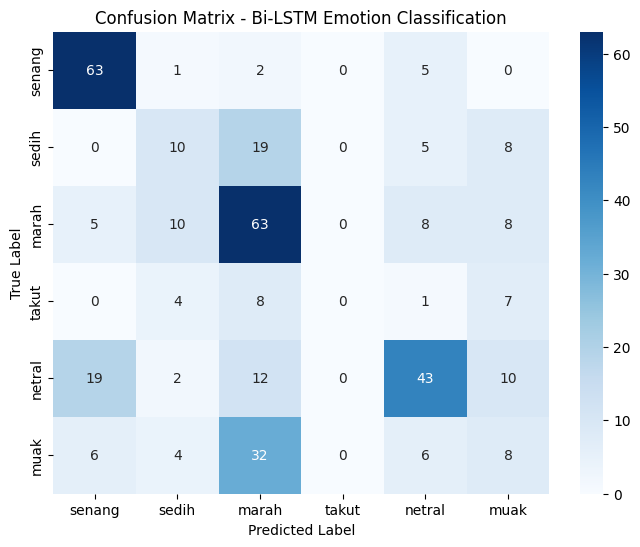

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Label mapping (harus sesuai urutan label_encoded)
# Make sure the labels correspond to the actual encoded labels used during training (0-5)
labels = ['senang', 'sedih', 'marah', 'takut', 'netral', 'muak']


# Prediksi pada data validasi
y_pred_prob = model.predict(X_val_pad) # Use X_val_pad as used in training/evaluation
y_preds_bilstm = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val_cat, axis=1) # Use y_val_cat to get true labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_preds_bilstm)

# Visualisasi
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Bi-LSTM Emotion Classification")
plt.show()

In [ ]:
# Contoh teks baru
new_text = ["GABISA LOG IN!"]

# Preprocessing: tokenisasi dan padding
new_seq = tokenizer.texts_to_sequences(new_text)
new_pad = pad_sequences(new_seq, maxlen=max_len)

# Prediksi
pred = model.predict(new_pad)
pred_label = np.argmax(pred, axis=1)
print(f"Prediksi Label: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediksi Label: [2]


In [ ]:
import pandas as pd
from collections import Counter

# Create a new DataFrame with the original text and the predicted labels
val_df_bilstm = pd.DataFrame({'content': X_val_pad.tolist(), 'label_encoded': y_val, 'predicted': val_preds_bilstm})

# Get the original text from df_ahm and add it to val_df_bilstm
val_texts = []
for i in val_df_bilstm.index:
    val_texts.append(df_ahm.loc[i, 'content'])
val_df_bilstm['text'] = val_texts


# Mapping ID label ke nama emosi
label_id_to_str = {
    0: 'senang',
    1: 'sedih',
    2: 'marah',
    3: 'takut',
    4: 'netral',
    5: 'muak'
}

# Hitung jumlah masing-masing label hasil prediksi Bi-LSTM
pred_counts_bilstm = Counter(val_df_bilstm['predicted'])
top5_bilstm = pred_counts_bilstm.most_common(5)

print("\n🔍 Hasil Prediksi Model: Bi-LSTM")
print("\n🔝 Top 5 Emosi (Prediksi Bi-LSTM):")
for label_id, count in top5_bilstm:
    emosi = label_id_to_str[label_id]
    print(f"{emosi}: {count} data")

# Tampilkan contoh kalimat dari masing-masing emosi
print("\n📌 Contoh Kalimat dari Prediksi Bi-LSTM:")
for label_id, _ in top5_bilstm:
    emosi = label_id_to_str[label_id]
    contoh_texts = val_df_bilstm[val_df_bilstm['predicted'] == label_id]['text'].head(5).tolist()

    print(f"\nEmosi: {emosi.upper()}")
    for text in contoh_texts:
        print(f"- {text}")


🔍 Hasil Prediksi Model: Bi-LSTM

🔝 Top 5 Emosi (Prediksi Bi-LSTM):
marah: 136 data
senang: 93 data
netral: 68 data
muak: 41 data
sedih: 31 data

📌 Contoh Kalimat dari Prediksi Bi-LSTM:

Emosi: MARAH
- Password gagal diperbaharui -_-
- Tolong dong jangan dikit² logout. Ganti pasword awal mulu. Kerjaan kami banyak. Profesional dikit lah.
- Kacau...karyawan dibatasin bw HP,tp semua dipaksa lwt online..mau ngirit budget tp nyusahin karyawan..mana aplikasi lemot,sering error..ribet bener
- Proses kpsm sangat lambat!
- Eror terus buang 2 kuota g bisa login Bu,buang2 Waktu

Emosi: SENANG
- Tolong lah ya sekelas AHM masa servernya berat banget
- gimana ini developer nya sih mau ganti password aja susah amat, kalo ngga bisa ngurus apk mending tanya tuh ama anak" smk udah banyak yang komplen masih aja ngga di urus
- Ini IT sekelas AHM bikin apk aja berantakan.. Nyusahin...
- Sudah ganti password 2 hari yang lalu, mau log in lagi malah salah password. Padahal password udh otomatis dan di save di